Consider the same linear model with a `tanh` activation function.

How about trying a different optimizer like stochastic gradient descent (SGD). Before training our network, let's split the data into a training and validation set.

In [1]:
%matplotlib inline

In [2]:
from collections import OrderedDict

import matplotlib.pyplot as plt
import torch

import torch.nn as nn
import torch.nn.functional
import torch.optim as optim

In [3]:
# Known Celsius temperature
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_c = torch.tensor(t_c).unsqueeze(1)

# Unknown temperature
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_u = torch.tensor(t_u).unsqueeze(1)

In [4]:
n_samples = t_u.shape[0]
n_val = int(0.34 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([10,  6,  0,  5,  2,  8,  1,  3]), tensor([7, 9, 4]))

In [5]:
t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

In [6]:
def training_loop(
    n_epochs,
    optimizer,
    model,
    loss_fn,
    t_u_train,
    t_u_val,
    t_c_train,
    t_c_val
):
    """Training loop for toy temperature data using an neural network module

    Parameters
    ----------
    n_epochs : int
        Number of iterations
    optimizer : torch.optim.Optimizer
        Optimizer class
    t_u_train : torch.Tensor
        Unknown temperature tensor for training
    t_u_val : torch.Tensor
        Target known temperature tensor for validation
    t_c_train : torch.Tensor
        Known temperature tensor for training
    t_c_val : torch.Tensor
        Known known temperature tensor for validation
    Returns
    -------
    None
    """
    for epoch in range(1, n_epochs + 1):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch < 5 or epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")


Epoch 1, Training loss 219.1075, Validation loss 101.8062
Epoch 2, Training loss 218.8213, Validation loss 101.6475
Epoch 3, Training loss 218.5354, Validation loss 101.4891
Epoch 4, Training loss 218.2498, Validation loss 101.3310
Epoch 1000, Training loss 80.6657, Validation loss 44.4734
Epoch 2000, Training loss 48.8237, Validation loss 47.3136
Epoch 3000, Training loss 31.5981, Validation loss 43.6183
Epoch 4000, Training loss 18.8678, Validation loss 36.9268
Epoch 5000, Training loss 10.5460, Validation loss 32.3851
output tensor([[ 4.8952],
        [16.4636],
        [13.4968]], grad_fn=<AddmmBackward0>)
answer tensor([[-4.],
        [13.],
        [11.]])
hidden tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.8540],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.0000],
        [0.8339],
        [0.0000],
        [0.0000]])


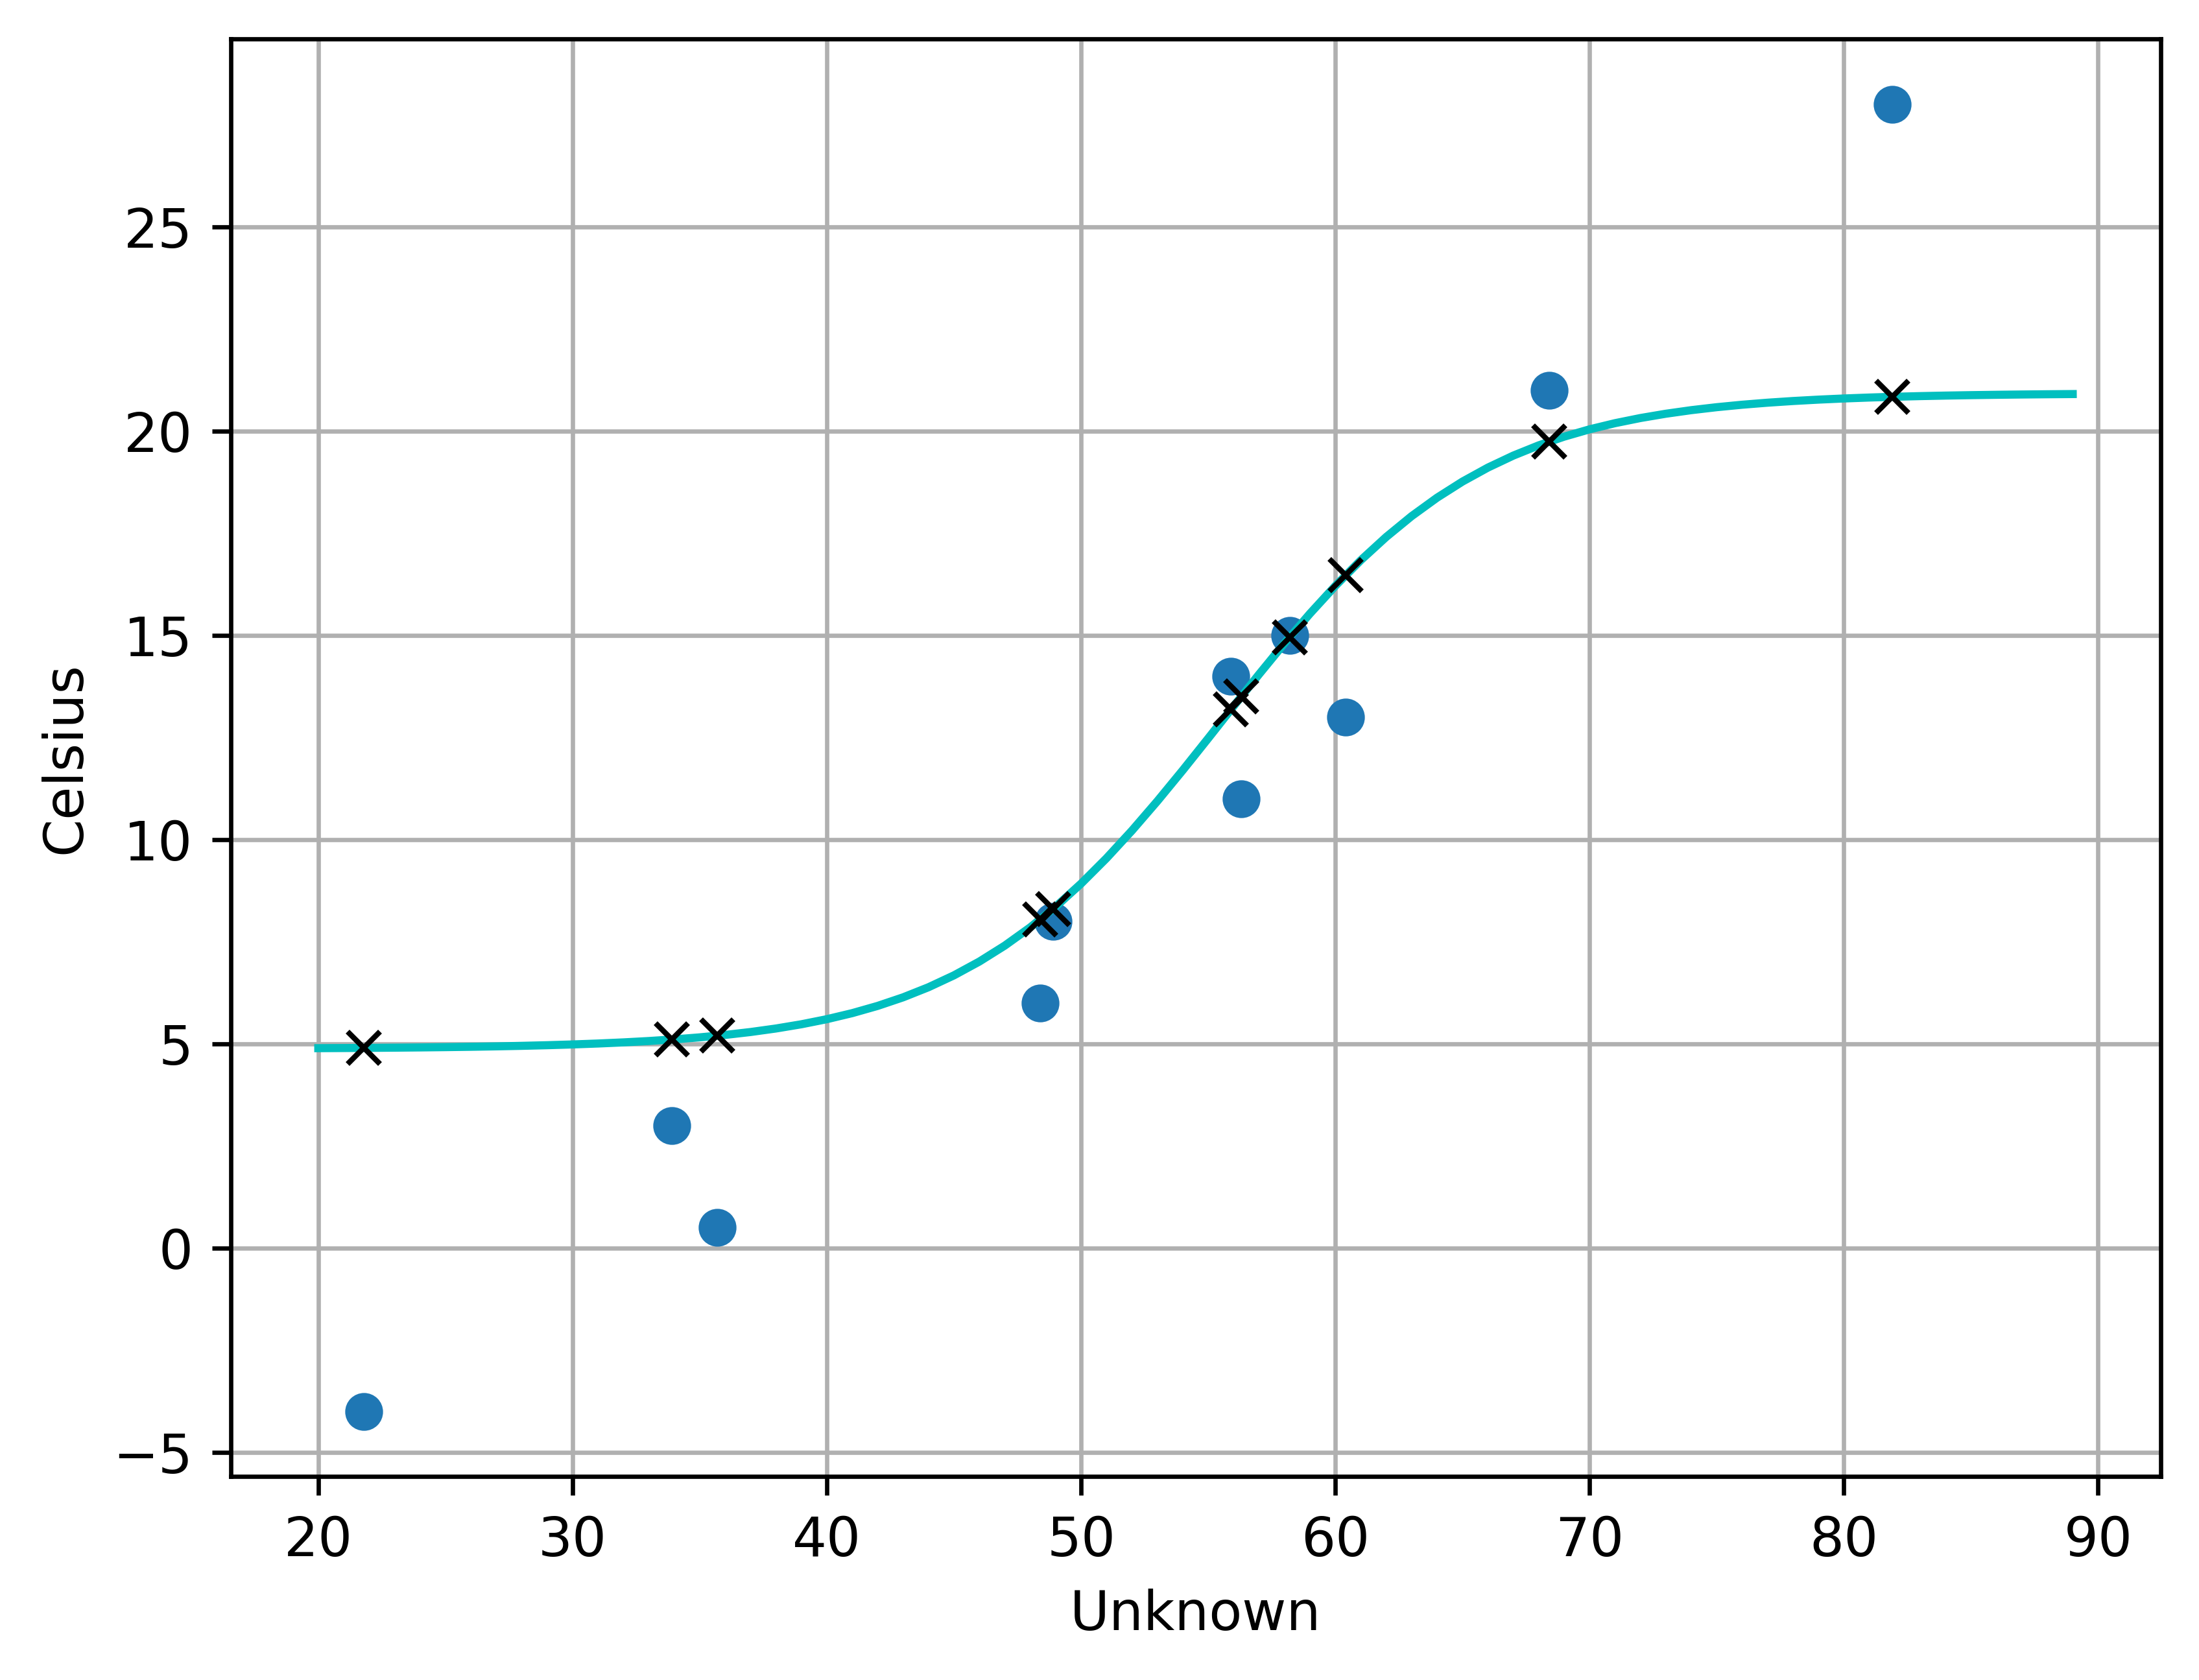

In [14]:
seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, n_samples)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(n_samples, 1))
]))

optimizer = optim.Adam(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_u_train,
    t_u_val = t_u_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_u_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

t_range = torch.arange(20., 90.).unsqueeze(1)

fig = plt.figure(dpi=600)
plt.xlabel("Unknown")
plt.ylabel("Celsius")
plt.grid(True)
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(t_u).detach().numpy(), 'kx')

__WOAH__. The model did a awful job. Why is that?

Because we did not normalize the data range. The activation function `tanh` is saturated well above 10.

Let's normalize our unknown temperature measurements to a magnitude that

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=20, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=20, out_features=1, bias=True)
) torch.Size([8, 1]) torch.Size([3, 1])
Epoch 1, Training loss 229.8940, Validation loss 107.8549
Epoch 2, Training loss 218.1360, Validation loss 100.9631
Epoch 3, Training loss 207.1883, Validation loss 94.6975
Epoch 4, Training loss 196.9965, Validation loss 89.0108
Epoch 1000, Training loss 1.9683, Validation loss 6.1486
Epoch 2000, Training loss 1.3013, Validation loss 5.8528
Epoch 3000, Training loss 1.2478, Validation loss 6.1920
Epoch 4000, Training loss 1.2159, Validation loss 6.5212
Epoch 5000, Training loss 1.1885, Validation loss 6.8444
output tensor([[-1.6258],
        [16.1996],
        [13.1587]], grad_fn=<AddmmBackward0>)
answer tensor([[-4.],
        [13.],
        [11.]])
hidden tensor([[-0.0011],
        [ 0.0010],
        [-0.0042],
        [ 0.0062],
        [ 0.0149],
        [ 0.0049],


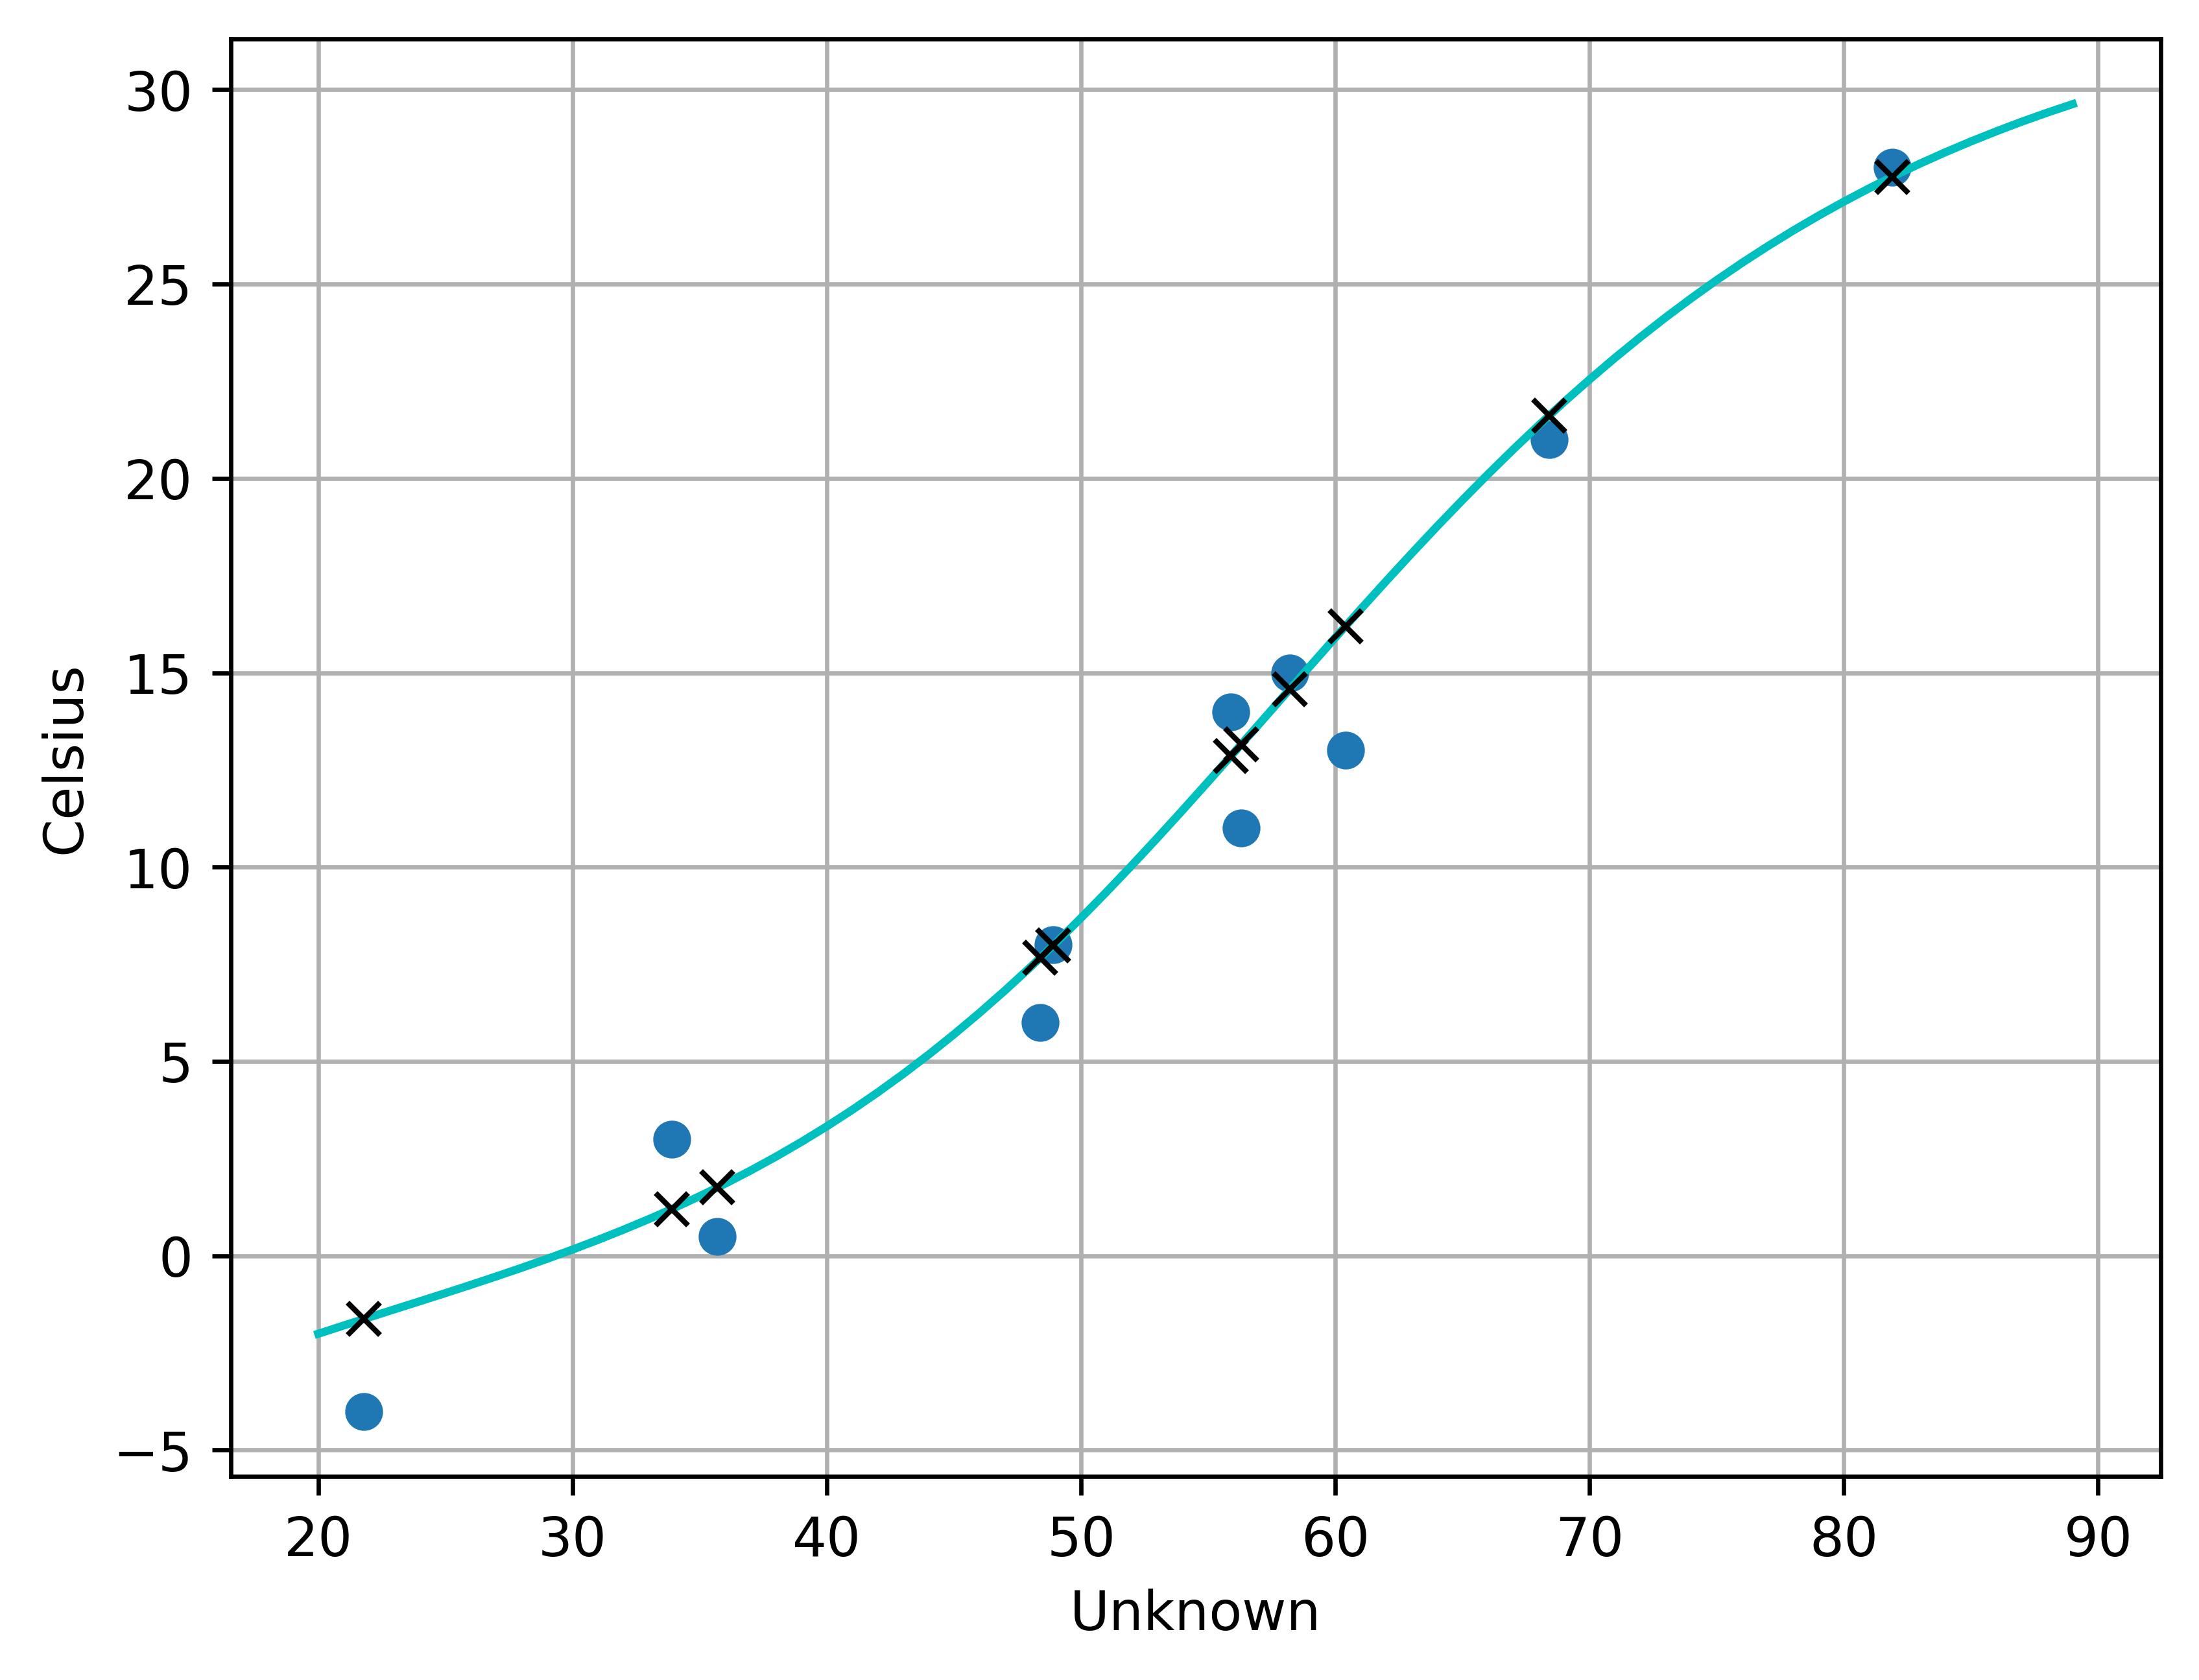

In [13]:
t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 20)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(20, 1))
]))

optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)
print(seq_model, t_un_train.shape, t_un_val.shape)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)

print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

fig = plt.figure(dpi=600)
plt.xlabel("Unknown")
plt.ylabel("Celsius")
plt.grid(True)
plt.plot(t_u.numpy(), t_c.numpy(), 'o')
plt.plot(t_range.numpy(), seq_model(0.1 * t_range).detach().numpy(), 'c-')
plt.plot(t_u.numpy(), seq_model(0.1 * t_u).detach().numpy(), 'kx')